#     Mr. Robot's Object Detector on Toy Reindeer, Training Notebook 
## by:  Steven Smiley

* [1: Purpose](#Code_Objective_1)
* [2: Import Libraries](#Code_Objective_2)
* [3: Import and View Data](#Code_Objective_3)
    * [3.1: Split Data for Training](#Code_Objective_3.1)
    * [3.2: Data Augmentation](#Code_Objective_3.2)
* [4: SSD MobileNet V2 FPNLite 320x320 Download from Model Zoo](#Code_Objective_4)
* [5: SSD MobileNet V2 FPNLite 320x320 Get Checkpoints and Configs Paths](#Code_Objective_5)
* [6: SSD MobileNet V2 FPNLite 320x320 Restore Weights](#Code_Objective_6)
* [7: SSD MobileNet V2 FPNLite 320x320 Training](#Code_Objective_7)
* [8: Export New Tflite Model](#Code_Objective_8)
* [9: Evaluate Test Images](#Code_Objective_9)
    * [9.1: Evaluate Feature Maps](#Code_Objective_9.1)
* [10: Create A GIF](#Code_Objective_10)
* [11: References](#Code_Objective_11)

# 1. Purpose<a class="anchor" id="Code_Objective_1"></a>
The purpose of this Jupyter notebook is to train the **SSD MobileNet V2 FPNLite 320x320**[2](#Ref_2) for making a custom object detector on a toy reindeer.  The output tflite model will be deployed onto a Raspberry Pi 4 Model B, using the Coral Edge TPU for inference.  This is the how the DIY robot will be able to autonomously aim/shoot/retrieve the toy reindeer. 

This notebook uses Transfer Learning by extracting the already trained weights from the Model Zoo[1](#Ref).  It retrains the weights of the SSD, but not the feature extractor, MobileNet V2.  It restores weights from the regression SSD, but not the classification weights since we are training a new class.  The feature extractor weights are not changed/trained.  

# 2. Import Libraries <a class="anchor" id="Code_Objective_2"></a>

In [ ]:
# Support for TF2 models was added after TF 2.3.
!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

# 3. Import and View Data <a class="anchor" id="Code_Objective_3"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive",force_remount=True)

In [ ]:
image_dir = '/content/drive/MyDrive/Images/Toy_Images'
train_image_dir=image_dir
test_image_dir=image_dir

In [ ]:
image_list=[]
image_label_list=[]
for row in os.listdir(image_dir):
  if row.find('._')==-1:
    if row.find('.jpg')!=-1:
      dummy=row.split('.jpg')[0]+'.txt'
      for row2 in os.listdir(image_dir):
        if dummy==row2:
          image_list.append(row)
          image_label_list.append(dummy)

In [ ]:
import pandas as pd
df=pd.DataFrame((image_list,image_label_list)).T
df=df.sort_values(by=[0,1]).reset_index().drop('index',axis=1)
df

0                                        1
0         148_2021-05-07_21c40c32p150436.jpg       148_2021-05-07_21c40c32p150436.txt
1         157_2021-05-07_21c40c39p511851.jpg       157_2021-05-07_21c40c39p511851.txt
2         168_2021-05-07_21c40c48p928617.jpg       168_2021-05-07_21c40c48p928617.txt
3         189_2021-05-07_21c41c06p698927.jpg       189_2021-05-07_21c41c06p698927.txt
4         196_2021-05-07_21c41c12p521275.jpg       196_2021-05-07_21c41c12p521275.txt
..                                       ...                                      ...
250  reindeer_2021-05-05_19c18c16p242493.jpg  reindeer_2021-05-05_19c18c16p242493.txt
251  reindeer_2021-05-05_19c18c23p420774.jpg  reindeer_2021-05-05_19c18c23p420774.txt
252  reindeer_2021-05-05_19c18c25p937474.jpg  reindeer_2021-05-05_19c18c25p937474.txt
253  reindeer_2021-05-05_19c18c37p334318.jpg  reindeer_2021-05-05_19c18c37p334318.txt
254  reindeer_2021-05-05_19c18c48p435443.jpg  reindeer_2021-05-05_19c18c48p435443.txt

[255 rows x 2 columns]

# 3.1 Split Data For Training <a class="anchor" id="Code_Objective_3.1"></a>

In [ ]:
total_num_images=len(df)
total_num_images

255

In [ ]:
#60% training because we will augment many more.  Rather have more testing images
train_num_images=round(0.6*total_num_images)
train_num_images

153

In [ ]:
import random
random.seed(42) #random seed number 42 for reproducibility
total_list = random.sample(range(0, total_num_images), total_num_images)
df=df.loc[total_list].reset_index().drop('index',axis=1).copy()
train_list = random.sample(range(0, total_num_images), train_num_images)
test_list=[]
for item in range(0,total_num_images):
  if item not in train_list:
    test_list.append(item)
print(f'# test images = {len(test_list)}')
print(f'# train iamges = {len(train_list)}')
print((len(test_list)+len(train_list),total_num_images))
train_images=df.loc[train_list].reset_index().drop('index',axis=1)
test_images=df.loc[test_list].reset_index().drop('index',axis=1)

# test images = 102
# train iamges = 153
(255, 255)


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None, thresh=0.4):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    thresh: the cutoff threshold for bounding box
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=thresh)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

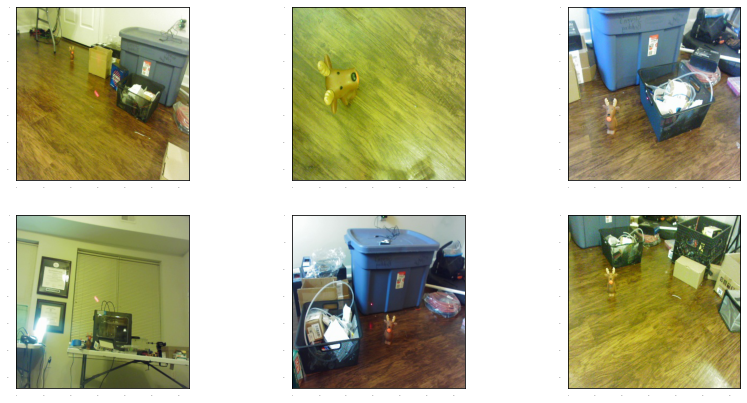

In [ ]:
# Load images and visualize
train_images_np = []
for count,i in enumerate(train_images[0]):
  image_path = os.path.join(train_image_dir, i)
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  try:
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
  except:
    pass
plt.show()

In [ ]:
len_train_images_og=len(train_images_np)
len_train_images_og

153

In [ ]:
def get_box(path):
  f=open(path,'r')
  f_read=f.readlines()
  f.close()
  x_avg=f_read[0].split(' ')[1].strip()
  x_avg=float(x_avg)
  y_avg=f_read[0].split(' ')[2].strip()
  y_avg=float(y_avg)
  x2_x1=f_read[0].split(' ')[3].strip()
  x2_x1=float(x2_x1)
  y2_y1=f_read[0].split(' ')[4].strip()
  y2_y1=float(y2_y1)
  x1=x_avg-x2_x1
  x2=x_avg+x2_x1
  y1=y_avg-y2_y1
  y2=y_avg+y2_y1
  return np.array([[y1,x1,y2,x2]],dtype=np.float32)

In [ ]:
gt_boxes = []
for i in train_images[1]:
  gt_box_path = os.path.join(train_image_dir,i)
  gt_i=get_box(gt_box_path)
  gt_boxes.append(gt_i)

In [ ]:
len(gt_boxes)

153

In [ ]:
test_gt_boxes = []
for i in test_images[1]:
  gt_box_path = os.path.join(test_image_dir,i)
  gt_i=get_box(gt_box_path)
  test_gt_boxes.append(gt_i)

In [ ]:
max_size=tf.convert_to_tensor(np.squeeze(train_images_np[0].shape[0:-1]),dtype=tf.int32)
max_size

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([320, 320], dtype=int32)>

In [ ]:
max_size.numpy()

array([320, 320], dtype=int32)

# 3.2 Data Augmentation <a class="anchor" id="Code_Objective_3.2"></a>

In [ ]:
def augment_images(data_og,dboxes_og,shrink_jitter_box=False,shrink_jitter_replace=False,rand_crop=False,rand_brightness=False,rand_adj_sat=False,rand_hue=False,horiz_flip=False,vert_flip=False,rand_black_patches=False):
    import object_detection.core.preprocessor as preprocessor_tf
    data_final=data_og.copy()
    dboxes_final=dboxes_og.copy()
    if shrink_jitter_box==True:
      # random shrink jitter box
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(dboxes)):
        new_box_i=preprocessor_tf.random_jitter_boxes(tf.convert_to_tensor(dboxes[i],dtype=tf.float32),ratio=0.45,jitter_mode='shrink')
        new_box.append(new_box_i)
      new_image=data
      new_box=[w.numpy() for w in new_box]
      if shrink_jitter_replace==True:
        data_final=new_image
        dboxes_final=new_box
      else:
        data_final=data_final+new_image
        dboxes_final=dboxes_final+new_box
    if rand_crop==True:
      ## random crop
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i,new_box_i,new_label_i,new_weight_i=preprocessor_tf.random_crop_image(tf.convert_to_tensor(data[i]/255,dtype=tf.float32),
                                                                              tf.convert_to_tensor(dboxes[i],dtype=tf.float32),
                                                                              tf.convert_to_tensor(np.array([[1]],dtype=np.float32)),
                                                                              tf.convert_to_tensor(np.array([[1]],dtype=np.float32)))
        
        new_image_i,new_box_i=preprocessor_tf.random_pad_image(new_image_i,new_box_i,min_image_size=max_size,max_image_size=max_size)
        new_image.append(new_image_i*255)
        new_box.append(new_box_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=[w.numpy() for w in new_box]
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if rand_brightness==True:
      ## random adjust brightness
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i=preprocessor_tf.random_adjust_brightness(tf.convert_to_tensor(data[i],dtype=tf.float32),max_delta=0.5)
        new_image.append(new_image_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=dboxes
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if rand_adj_sat==True:
      ## random adjust saturation
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i=preprocessor_tf.random_adjust_saturation(tf.convert_to_tensor(data[i],dtype=tf.float32))
        new_image.append(new_image_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=dboxes
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if rand_hue==True:
      ## random adjust hue
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i=preprocessor_tf.random_adjust_hue(tf.convert_to_tensor(data[i],dtype=tf.float32))
        new_image.append(new_image_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=dboxes
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if vert_flip==True:
      ## random vertical flip
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i,new_box_i=preprocessor_tf.random_vertical_flip(tf.convert_to_tensor(data[i]/255,dtype=tf.float32),
                                                                              tf.convert_to_tensor(dboxes[i],dtype=tf.float32),probability=1)
        
        new_image.append(new_image_i*255)
        new_box.append(new_box_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=[w.numpy() for w in new_box]
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if horiz_flip==True:
      ## random horizontal flip
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i,new_box_i=preprocessor_tf.random_horizontal_flip(tf.convert_to_tensor(data[i]/255,dtype=tf.float32),
                                                                              tf.convert_to_tensor(dboxes[i],dtype=tf.float32),probability=1)
        
        new_image.append(new_image_i*255)
        new_box.append(new_box_i)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=[w.numpy() for w in new_box]
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    if rand_black_patches==True:
      ## random black patches
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(data)):
        new_image_i=preprocessor_tf.random_black_patches(tf.convert_to_tensor(data[i]/255,dtype=tf.float32)                                       )
        new_box.append(tf.convert_to_tensor(dboxes[i],dtype=tf.float32))
        new_image.append(new_image_i*255)
      new_image=np.array(new_image,dtype=np.uint8)
      new_box=[w.numpy() for w in new_box]
      data_final=data_final+list(new_image)
      dboxes_final=dboxes_final+new_box
    return data_final,dboxes_final


In [ ]:
data_augmentation=True

In [ ]:
# fix the crops to be tighter
train_images_np,gt_boxes=augment_images(train_images_np,gt_boxes,
                                          shrink_jitter_box=True,
                                          shrink_jitter_replace=True,
                                          rand_brightness=False,
                                          rand_adj_sat=False,
                                          rand_hue=False,
                                          horiz_flip=False,
                                          vert_flip=False,
                                          rand_black_patches=False)

In [ ]:
if data_augmentation==True:
  train_images_np,gt_boxes=augment_images(train_images_np,gt_boxes,
                                          shrink_jitter_box=False,
                                          shrink_jitter_replace=False,
                                          rand_crop=True,
                                          rand_brightness=True,
                                          rand_adj_sat=True,
                                          rand_hue=True,
                                          horiz_flip=True,
                                          vert_flip=True,
                                          rand_black_patches=True)

Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
object_class_id = 1
num_classes = 1

category_index = {object_class_id: {'id': object_class_id, 'name': 'reindeer'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [ ]:
len(gt_boxes)

1224

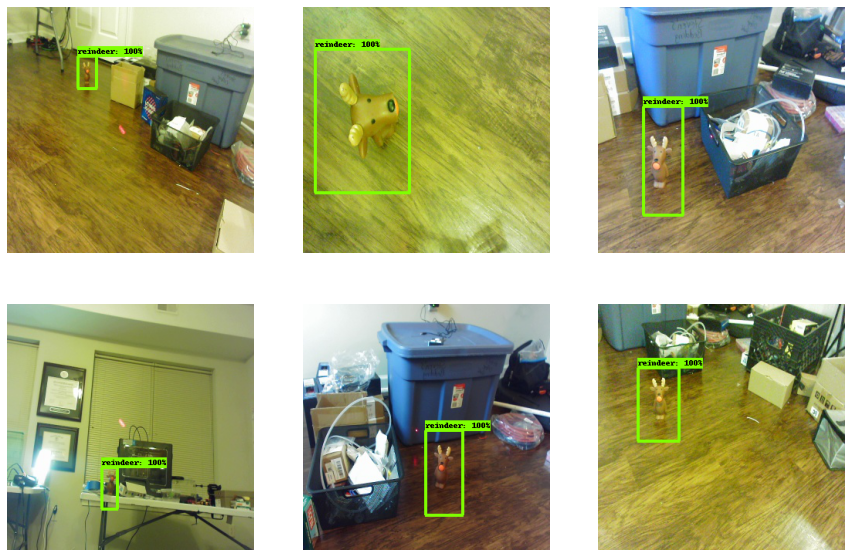

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(15, 10))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
  plt.axis('off')
plt.show()

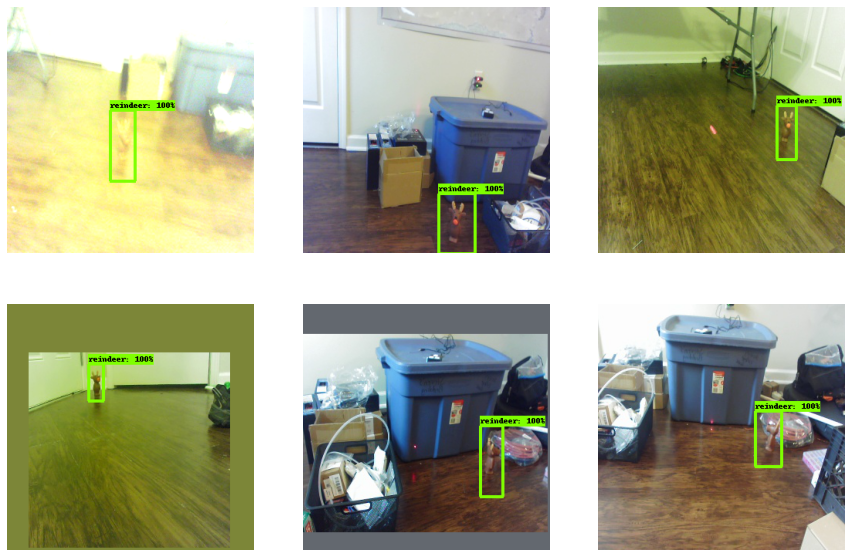

In [ ]:
random_list=np.arange(-len(train_images_np)//2,-len(train_images_np),-1)
np.random.shuffle(random_list)
random_list[0:6]
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(15, 10))
for i,idx in enumerate(random_list[0:6]):
  plt.subplot(2, 3, i+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
  plt.axis('off')
plt.show()

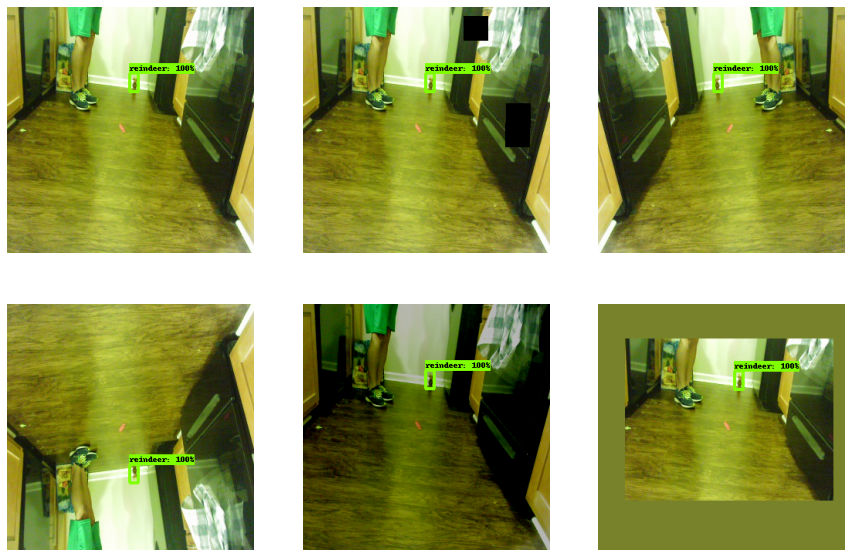

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

fig=plt.figure(figsize=(15, 10))
for i,j in enumerate([0,1,2,3,6,7]):
  idx=-(len_train_images_og*j)+len_train_images_og//2+5
  plt.subplot(2, 3, i+1)

  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
  plt.axis('off')
plt.show()

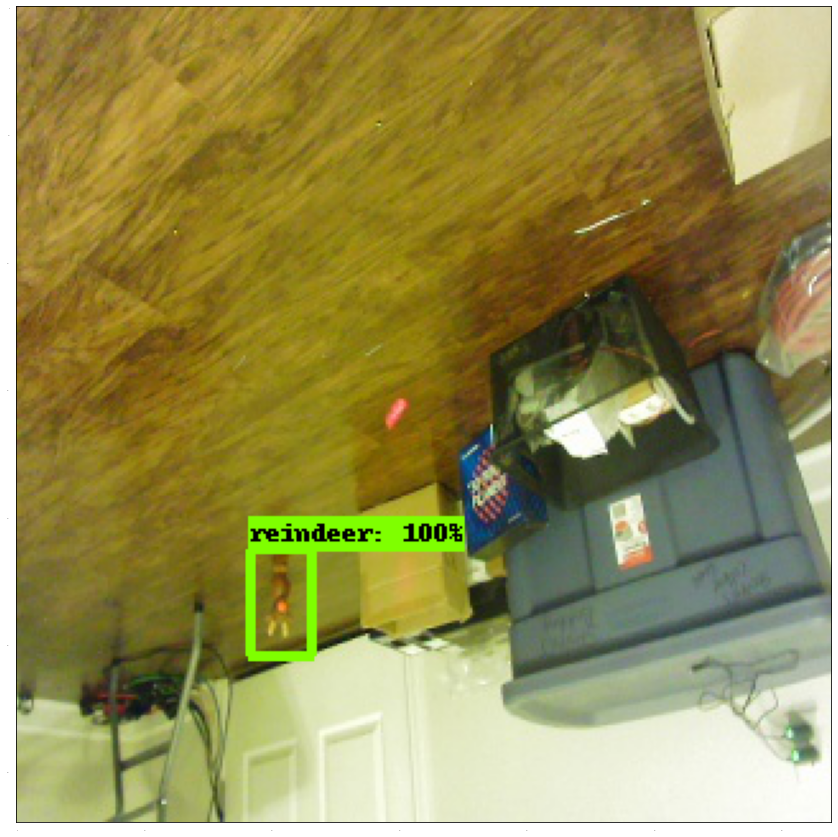

In [ ]:
i=-len_train_images_og*3#-60
plt.figure(figsize=(30, 15))
plot_detections(
    train_images_np[i],
    gt_boxes[i],
    np.ones(shape=[gt_boxes[i].shape[0]], dtype=np.int32),
    dummy_scores, category_index)
plt.show()

In [ ]:
train_images_np[-1].shape

(320, 320, 3)

# 4.  SSD MobileNet V2 FPNLite 320x320 Download from Model Zoo <a class="anchor" id="Code_Objective_4"></a>

In [ ]:
tf.keras.models

<module 'tensorflow.keras.models' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/models/__init__.py'>

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-05-08 21:52:09--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.128.128, 2607:f8b0:4001:c32::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.128.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M   111MB/s    in 0.2s    

2021-05-08 21:52:09 (111 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



# 5.  SSD MobileNet V2 FPNLite 320x320 Get Checkpoints and Configs Paths <a class="anchor" id="Code_Objective_5"></a>

In [ ]:
tf.keras.backend.clear_session()

#print('Building model and restoring weights for fine-tuning...', flush=True)
print('Building model and restoring weights for fine-tuning...', flush=False)
num_classes = 1

## Note, if you are restoring from a previous checkpoint, 
## then point to your respective directory, 
## else uncomment the following line and comment the one after.
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
#pipeline_config='/content/drive/MyDrive/Colab Notebooks/MrRobot/augmented_ssd_MobileNet_v2_FPNLite_320x320 5_7_2021_reindeer/output/pipeline.config'

## Note, if you are restoring from a previous checkpoint, 
## then point to your respective directory, 
## else uncomment the following line and comment the one after.
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'
#checkpoint_path ='/content/drive/MyDrive/Colab Notebooks/MrRobot/augmented_ssd_MobileNet_v2_FPNLite_320x320 5_7_2021_reindeer/output/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new reindeer class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
configs

Building model and restoring weights for fine-tuning...


{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
     

# 6.  SSD MobileNet V2 FPNLite 320x320 Restore Weights <a class="anchor" id="Code_Objective_6"></a>

In [ ]:
model_config = configs['model']
#model_config=configs
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    #_prediction_heads=detection_model._box_predictor._prediction_heads, #sjs edit 4/30 so that restored from weights works
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')


INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


# 7. SSD MobileNet V2 FPNLite 320x320 Training <a class="anchor" id="Code_Objective_7"></a>

In [ ]:
tf.keras.backend.set_learning_phase(True)

batch_size = 32
learning_rate = 0.01
num_batches = 50000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

def train_opt(learning_rate,detection_model,to_fine_tune):
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  train_step_fn = get_model_train_step_function(
      detection_model, optimizer, to_fine_tune)
  return train_step_fn
train_step_fn=train_opt(learning_rate,detection_model,to_fine_tune)

print('Starting fine-tuning', flush=True)
loss_counter=[]
loss_getting_worse=0
df_loss=[]
df_loss=pd.DataFrame(columns=['idx','mean loss'])
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]


  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
  loss_counter.append(total_loss.numpy())
  if len(loss_counter)>200:
    loss_previous=np.array(loss_counter[-200:-100])
    loss_current=np.array(loss_counter[-100:-1])
    loss_counter=loss_counter[-200:-1]
    loss_previous_mean_batch=loss_previous.mean()
    loss_current_mean_batch=loss_current.mean()
    #print(np.array(delta_i_list).mean())
    if (loss_previous_mean_batch-loss_current_mean_batch)<0.001:
      learning_rate=np.random.choice([0.001,0.01])
      print(f'New Learning Rate: {learning_rate}')
      ckpt_manager.save()
      print('Checkpoint saved')
      print('Re-starting fine-tuning', flush=True)
      train_opt(learning_rate,detection_model,to_fine_tune)
      loss_getting_worse+=1
      loss_counter=[]
    else:
      loss_getting_worse-=1
  if loss_getting_worse>20:
    break
  if idx % 100 == 0:
    if idx!=0:
      total_loss_for_batch_i=np.array(loss_counter[-100:-1]).mean()
    else:
      total_loss_for_batch_i=1000
    print(f'batch {str(idx)} of {str(num_batches)}, mean loss={total_loss_for_batch_i}: ',flush=True)
    df_i=pd.DataFrame([(idx,total_loss_for_batch_i)],columns=['idx','mean loss'])
    df_loss=df_loss.append(df_i,ignore_index=True)
    if idx==100:
      df_loss['mean loss'][0]=df_loss['mean loss'][1]
print('Finished fine-tuning')

ckpt_manager.save()
print('Final Checkpoint saved')

Starting fine-tuning


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 50000, mean loss=1000: 
batch 100 of 50000, mean loss=1.204797625541687: 
batch 200 of 50000, mean loss=0.8765740990638733: 
batch 300 of 50000, mean loss=0.8285770416259766: 
batch 400 of 50000, mean loss=0.7849316596984863: 
batch 500 of 50000, mean loss=0.7539636492729187: 
batch 600 of 50000, mean loss=0.7306479215621948: 
batch 700 of 50000, mean loss=0.7154713869094849: 
batch 800 of 50000, mean loss=0.7061752676963806: 
batch 900 of 50000, mean loss=0.695151686668396: 
batch 1000 of 50000, mean loss=0.6833599209785461: 
batch 1100 of 50000, mean loss=0.6681824326515198: 
batch 1200 of 50000, mean loss=0.6620433926582336: 
batch 1300 of 50000, mean loss=0.6623767018318176: 
batch 1400 of 50000, mean loss=0.6555784344673157: 
batch 1500 of 50000, mean loss=0.6438091993331909: 
batch 1600 of 50000, mean loss=0.6367953419685364: 
batch 1700 of 50000, mean loss=0.6306315660476685: 
batch 1800 of 50000, mean loss=0.6279466152191162: 
New Learning Rate: 0.001
Checkpoint save

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


batch 49400 of 50000, mean loss=0.4459058940410614: 
batch 49500 of 50000, mean loss=0.4432015120983124: 
New Learning Rate: 0.01
Checkpoint saved
Re-starting fine-tuning
batch 49600 of 50000, mean loss=0.45896151661872864: 
batch 49700 of 50000, mean loss=0.4440253674983978: 
New Learning Rate: 0.001
Checkpoint saved
Re-starting fine-tuning
batch 49800 of 50000, mean loss=0.46880877017974854: 
batch 49900 of 50000, mean loss=0.4578326940536499: 
Finished fine-tuning
Final Checkpoint saved


In [ ]:
df_loss

idx mean loss
0        0    1.2048
1      100    1.2048
2      200  0.876574
3      300  0.828577
4      400  0.784932
..     ...       ...
495  49500  0.443202
496  49600  0.458962
497  49700  0.444025
498  49800  0.468809
499  49900  0.457833

[500 rows x 2 columns]

In [ ]:
file_id='augmented_ssd_MobileNet_v2FPNLite_320_5_8_2021_reindeer_'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


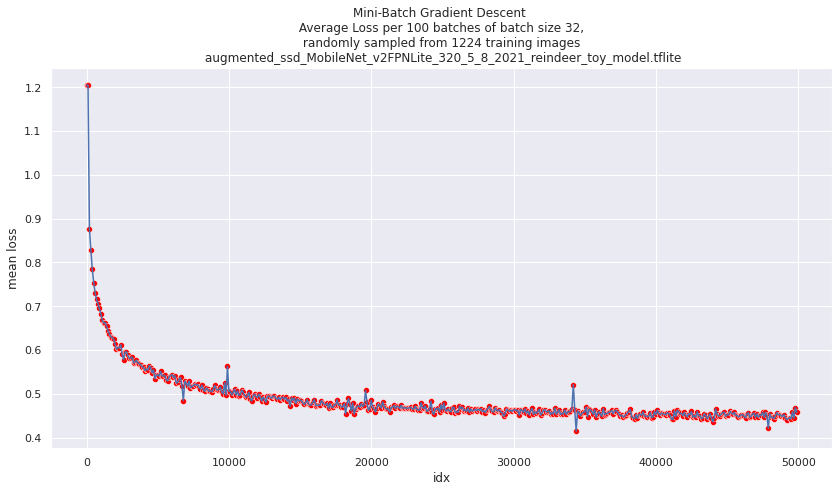

In [ ]:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme()
    sns.scatterplot(df_loss['idx'],df_loss['mean loss'],color='red').set(title='Mini-Batch Gradient Descent \n Average Loss per 100 batches of batch size {}, \n randomly sampled from {} training images \n {}toy_model.tflite'.format(batch_size,len(train_images_np),file_id))
    sns.lineplot(data=df_loss.astype(float),x='idx',y='mean loss')

In [ ]:
import importlib
importlib.reload(sns)
sns.reset_defaults()


# 8. Export New Tflite Model <a class="anchor" id="Code_Objective_8"></a>

In [ ]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2021-05-09 03:06:14.936381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-09 03:06:17.629132: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 03:06:17.631546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-09 03:06:17.641273: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-09 03:06:17.641315: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0682f30542a0): /proc/driver/nvidia/version does not exist
2021-05-09 03:06:17.641571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [ ]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/augmented_ssd_MobileNet_v2FPNLite_320_5_8_2021_reindeer_model_toy.tflite

2021-05-09 03:07:01.232035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-09 03:07:03.237338: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-09 03:07:03.238204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-09 03:07:03.246163: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-09 03:07:03.246196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0682f30542a0): /proc/driver/nvidia/version does not exist
2021-05-09 03:07:03.246400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

# 9. Evaluate Test Images <a class="anchor" id="Code_Objective_9"></a>

In [ ]:
test_images_np = []
for i in test_images[0]:
  image_path = os.path.join(test_image_dir, i)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor,data):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  # sjs edit 2/27/2021, trying to see input_data instead of preprocessed_image
  #preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  

  input_data= tf.convert_to_tensor(data[i], dtype=tf.float32)
  #interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())
  interpreter.set_tensor(input_details[0]['index'], input_data/255)

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/{}model_toy.tflite".format(file_id))
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor,test_images_np)
  if np.max(scores)>0.4:
    plot_detections(
        test_images_np[i][0],
        boxes[0],
        classes[0].astype(np.uint32) + label_id_offset,
        scores[0],
        category_index, figsize=(15, 20), image_name="Gif_frame_" + ('%02d' % i) + ".jpg", thresh=max(np.max(scores)-0.01,0.4))

In [ ]:
test_images_np[0],test_gt_boxes=augment_images(test_images_np[0],test_gt_boxes,shrink_jitter_box=True,shrink_jitter_replace=True)

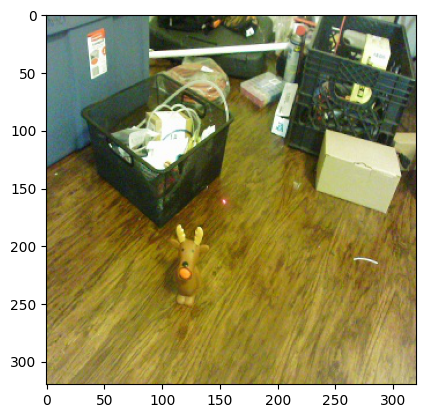

In [ ]:
label_id_offset = 1
i=-1
input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
boxes, classes, scores = detect(interpreter, input_tensor,test_images_np)
plot_detections(
    test_images_np[i][0],
    boxes[0],
    classes[0].astype(np.uint32) + label_id_offset,
    scores[0],
    category_index, figsize=(15, 20), thresh=max(np.max(scores)-0.01,0.5))

In [ ]:
classes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
scores

array([[0.4775586 , 0.40163887, 0.36776552, 0.23378077, 0.22542477,
        0.21698621, 0.20504016, 0.183911  , 0.17383868, 0.17147437]],
      dtype=float32)

In [ ]:
boxes[boxes<0]=0

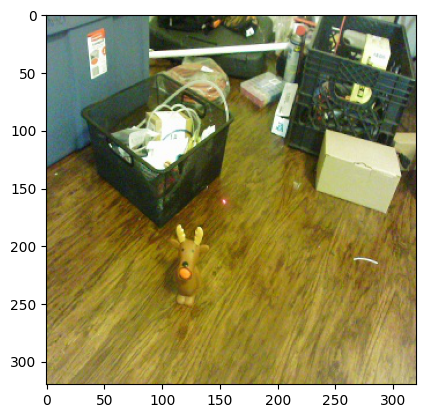

In [ ]:
img_i_np=np.squeeze(test_images_np[i])
img_i=plt.imshow(img_i_np)
img_i

In [ ]:
test_gt_boxes[1]

array([[0.221875, 0.432812, 1.009375, 0.764062]], dtype=float32)

In [ ]:
boxes[0][0]

array([0.5240114 , 0.30332503, 0.84967685, 0.45434502], dtype=float32)

In [ ]:
W,H,C=img_i_np.shape
ymin=np.int(H*boxes[0][0][0])
xmin=np.int(W*boxes[0][0][1])
ymax=np.int(H*boxes[0][0][2])
xmax=np.int(W*boxes[0][0][3])
ymin,ymax,xmin,xmax

(167, 271, 97, 145)

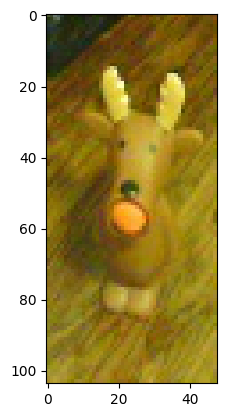

In [ ]:
img_i=plt.imshow(img_i_np[ymin:ymax,xmin:xmax])

# 9.1 Evaluate Feature Maps <a class="anchor" id="Code_Objective_9.1"></a>

(1, 40, 40, 128)
(1, 20, 20, 128)
(1, 10, 10, 128)
(1, 5, 5, 128)
(1, 3, 3, 128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


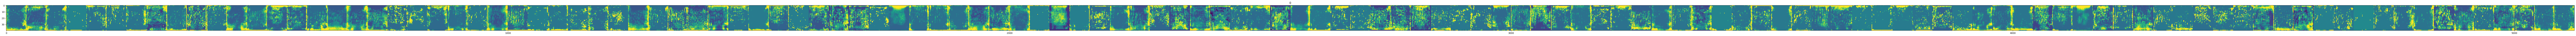

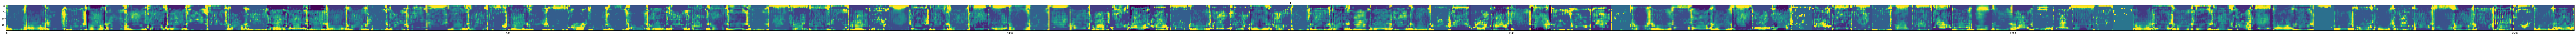

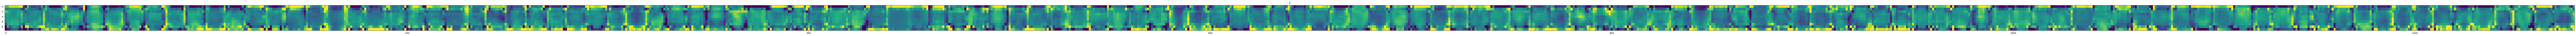

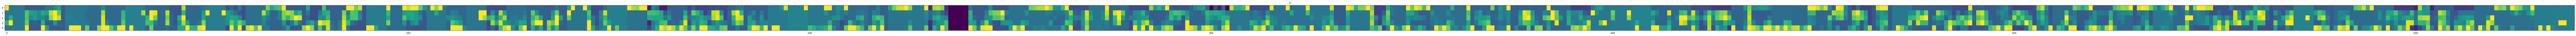

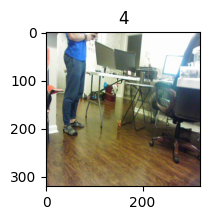

In [ ]:
img_i_np=np.squeeze(train_images_np[10])
from tensorflow import keras
predicted_i=detection_model.predict(tf.expand_dims(img_i_np,axis=0),[W,H,C])
for layer_index in range(0,len(predicted_i)-1):
  layer_i=predicted_i['feature_maps'][layer_index].numpy()
  print(layer_i.shape)
  n_features=layer_i.shape[-1]
  fs=layer_i.shape[1]
  convolutions_grid=np.zeros((fs,fs*n_features))
  for i in range(n_features):
    x=layer_i[0,:,:,i]
    x-=x.mean()
    x/=x.std()
    x*=64
    x+=128
    x=np.clip(x,0,255).astype('uint8')
    convolutions_grid[:,i*fs:(i+1)*fs]=x

  scale=200./n_features
  plt.figure(figsize=(scale*n_features,2))
  plt.title(str(layer_index))
  plt.grid(False)
  
  plt.imshow(convolutions_grid,aspect='auto')
plt.imshow(img_i_np)

In [ ]:
def draw_bounding_box_on_image(image, xmin, ymin, xmax, ymax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image
# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)

In [ ]:
predicted_bboxes=[]
normalized_bboxes=[]
scores_bboxes=[]
for i in range(0,len(test_images_np)):
  label_id_offset = 1
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor,test_images_np)
  boxes_c=boxes[0].copy()
  predicted_bboxes.append(boxes[0][0])
  boxes_c=test_gt_boxes[i].copy()
  normalized_bboxes.append(test_gt_boxes[i][0])

  scores_bboxes.append(scores[0][0])

predicted_bboxes=np.asarray(predicted_bboxes)
normalized_bboxes=np.asarray(normalized_bboxes)
scores_bboxes=np.asarray(scores_bboxes)

In [ ]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou


#Calculates IOU and reports true positives and false positives based on IOU threshold
predicted_bboxes=np.asarray(predicted_bboxes)
normalized_bboxes=np.asarray(normalized_bboxes)
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
TP=((iou >= iou_threshold)) #True Positives
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))
FP=((iou < iou_threshold)) #False Positivies
#Precision=TP/(TP+FP)
#Recall=TP/(GT)

In [ ]:
df_AP=pd.DataFrame(np.zeros(shape=(len(normalized_bboxes),5)),columns=['score','TP/FP','Precision','Recall','Precision_inter']).astype(str)
df_AP['Precision_inter']=df_AP['Precision_inter'].astype(float)
df_AP['Precision']=df_AP['Precision'].astype(float)
df_AP['Recall']=df_AP['Recall'].astype(float)
df_AP['score']=df_AP['score'].astype(float)
for i,(score_i,TP_i,FP_i) in enumerate(zip(list(scores_bboxes),TP,FP)):
  if TP_i==True:
    df_AP.at[i,'TP/FP']='TP'
  else:
    df_AP.at[i,'TP/FP']='FP'
  df_AP.at[i,'score']=score_i
df_AP=df_AP.sort_values(by='score',ascending=False).reset_index().drop('index',axis=1)
TP_cum=0
GT=len(df_AP[df_AP['TP/FP']=='TP'])
print(f'GT = {GT}')
for i in range(len(df_AP)):
  if df_AP['TP/FP'][i]=='TP':
    TP_cum+=1
  df_AP.at[i,'Precision']=TP_cum/(i+1)
  df_AP.at[i,'Recall']=TP_cum/GT
df_AP=df_AP.sort_values(by='Recall',ascending=True).reset_index().drop('index',axis=1)
for i in range(len(df_AP)):
  if df_AP['TP/FP'][i]=='TP':
    df_AP.at[i,'Precision_inter']=df_AP['Precision'][i]
  else:
    if i>=1:
      #df_AP.at[i,'Precision_inter']=np.max((df_AP['Precision'][i],df_AP['Precision_inter'][i-1]))
      df_AP.at[i,'Precision_inter']=df_AP['Precision_inter'][i-1]
    elif i==0:
      df_AP.at[i,'Precision_inter']=df_AP['Precision'][i]
df_AP=df_AP.sort_values(by='Recall',ascending=False).reset_index().drop('index',axis=1)
for i in range(len(df_AP)-1):
  if df_AP['Precision_inter'][i]>=df_AP['Precision_inter'][i+1]:
    df_AP.at[i+1,'Precision_inter']=df_AP['Precision_inter'][i]
df_AP=df_AP.sort_values(by='Recall',ascending=True).reset_index().drop('index',axis=1)
df_AP.at[0,'Precision_inter']=df_AP['Precision'].max()


In [ ]:
df_AP['AUC']=0.0
mean_i=0.
for i in range(1,len(df_AP)):
  mean_i=(df_AP['Recall'][i]-df_AP['Recall'][i-1])*np.mean((df_AP['Precision_inter'][i-1],df_AP['Precision_inter'][i]))+mean_i
  df_AP.at[i,'AUC']=mean_i

In [ ]:
AP_50=max(df_AP['AUC'])
AP_50

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
fig=plt.figure(figsize=(10,6))
sns.scatterplot(df_AP['Recall'],df_AP['Precision'],color='Blue').set(title=f'Precision Recall Curve for AP_50= {np.round(AP_50,2)} \n {file_id}toy_model.tflite')
sns.lineplot(data=df_AP[['Recall','Precision']].astype(float),x='Recall',y='Precision')
sns.scatterplot(df_AP['Recall'],df_AP['Precision_inter'],color='Red')
sns.lineplot(data=df_AP[['Recall','Precision_inter']].astype(float),x='Recall',y='Precision_inter',legend='auto')
fig.legend(labels=['Precision','Precision_inter'],loc='lower left')
plt.show()

In [ ]:
import importlib
importlib.reload(sns)
sns.reset_defaults()
importlib.reload(plt)

In [ ]:
import cv2
n = 9
iou[np.where(iou<1e-4)]=0.0
indexes = np.random.choice(len(predicted_bboxes), size=n)
iou_to_draw = iou[indexes]
norm_to_draw = np.squeeze(np.asarray(test_images_np)[indexes.astype(int)])
display_digits_with_boxes(norm_to_draw, predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

# 10. Create A GIF <a class="anchor" id="Code_Objective_10"></a>

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'toy_test.gif'

filenames = glob.glob('Gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)
  #print(filename)
  #fi=plt.imread(filename)
  #plt.imshow(fi)
  #plt.show()

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))

# 11. References <a class="anchor" id="Code_Objective_11"></a>

1. TensorFlow 2 Detection Model Zoo, [https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md]<a class="anchor" id="Ref_1"></a>  

2. SSD MobilNet V2 FPNLite 320x320, [http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz] <a class="anchor" id="Ref_2"></a>   

3. Liu, Wei et al. "SSD: Single Shot MultiBox Detector" [https://arxiv.org/abs/1512.02325] <a class="anchor" id="Ref_3"></a>   

4. TensorFlow.  Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,Yuan Yu, and Xiaoqiang Zheng.  TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org. <a class="anchor" id="Ref_4"></a>   

5. LabelImg. [https://github.com/tzutalin/labelImg] <a class="anchor" id="Ref_5"></a>   

6. Bradski, G., & Kaehler, A. (2008). Learning OpenCV: Computer vision with the OpenCV library. " O&#x27;Reilly Media, Inc." <a class="anchor" id="Ref_6"></a>   

7.  SciPy. Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2019) SciPy 1.0–Fundamental Algorithms for Scientific Computing in Python. preprint arXiv:1907.10121 <a class="anchor" id="Ref_7"></a>   

8.  Python. a) Travis E. Oliphant. Python for Scientific Computing, Computing in Science & Engineering, 9, 10–20 (2007) b) K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers, Computing in Science & Engineering, 13, 9–12 (2011) <a class="anchor" id="Ref_8"></a>   

9.  NumPy. a) Travis E. Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006). b) Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22–30 (2011) <a class="anchor" id="Ref_9"></a>   

10.  IPython. a) Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21–29 (2007) <a class="anchor" id="Ref_10"></a>   

11.  Matplotlib. J. D. Hunter, “Matplotlib: A 2D Graphics Environment”, Computing in Science & Engineering, vol. 9, no. 3, pp. 90–95, 2007. <a class="anchor" id="Ref_11"></a>   

12.  Pandas. Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51–56 (2010) <a class="anchor" id="Ref_12"></a>   

13. Scikit-Learn. Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825–2830 (2011) <a class="anchor" id="Ref_13"></a>   

14.  Scikit-Image. Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014) <a class="anchor" id="Ref_14"></a>   